In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpyro
from numpyro.handlers import seed, trace, condition
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import logging
# Removing annoying TFP error message
logger = logging.getLogger("root")
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

import sbibm
from sbids.tasks import lotka_volterra, lotka_volterra_y_bijector, lotka_volterra_theta_bijector, get_samples_and_scores

rng_seq = hk.PRNGSequence(42)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
task = sbibm.get_task("lotka_volterra")
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1).reshape([2, 10]).T) # Reordering for numpyro
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

@jax.jit
def get_batch(key, batch_size=256):
    model = condition(lotka_volterra, {'z': jnp.array([30.,1.])})
    (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size)
    return samples['theta'], samples['y'].reshape([-1,20])

/home/francois/.local/lib/python3.10/site-packages/diffeqtorch/diffeqtorch.py:29: UserWarning: JULIA_SYSIMAGE_DIFFEQTORCH not set
  warn("JULIA_SYSIMAGE_DIFFEQTORCH not set")


In [3]:
from sbids.models import ConditionalRealNVP, AffineSigmoidCoupling

bijector = partial(AffineSigmoidCoupling, 
                   layers = [64,64],
                   n_components = 8, 
                   activation = jnp.sin)

NF = partial(ConditionalRealNVP, 
             n_layers = 4, 
             bijector_fn = bijector)

class SmoothNPE:
    def __call__(self, y):
        net = lotka_volterra_y_bijector(y)
        net = jnp.sin(hk.Linear(256, name='comp1')(net))
        net = jnp.sin(hk.Linear(256, name='comp2')(net))
        net = jnp.sin(hk.Linear(256, name='comp3')(net))
        net = hk.Linear(8, name='comp4')(net)
        nvp = NF(4)(net)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),
                                                      tfb.Scale(10.),
                                                      tfb.Shift(-0.5)]))

nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))

In [4]:
params_nd = nvp_nd.init(next(rng_seq), jnp.ones([1,4]), jnp.ones([1,20]))

In [5]:
losses = []

In [6]:
scheduler = optax.piecewise_constant_schedule(init_value=0.002, 
                                              boundaries_and_scales={5000: 0.1,
                                                                     10000: 0.5,
                                                                     15000: 0.1})
optimizer = optax.adam(learning_rate=scheduler)
opt_state = optimizer.init(params_nd)

In [7]:
def loss_fn(params, weight, mu, batch):
    log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,-1])).squeeze()))(mu, batch)
    return -jnp.mean(log_prob) 

@jax.jit
def update(params, opt_state, weight, mu, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [ ]:
for step in range(20000):
    batch = get_batch(next(rng_seq))
    l, params_nd, opt_state = update(params_nd, opt_state, 1.0, batch[0],batch[1])
    if (step % 100) == 0 :
        print('Iter %d :'%step, mean(losses[50:]), scheduler(opt_state[1].count))
    losses.append(l)

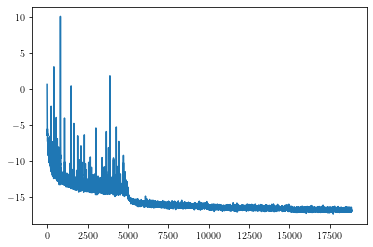

In [170]:
plot(losses)

In [168]:
nvp_sample_nd = hk.transform(lambda x: SmoothNPE()(x).sample(10000, seed=hk.next_rng_key()))
sample_nd = nvp_sample_nd.apply(params_nd, rng = next(rng_seq), x = observation.reshape([-1,20])*jnp.ones([int(10000),20]))

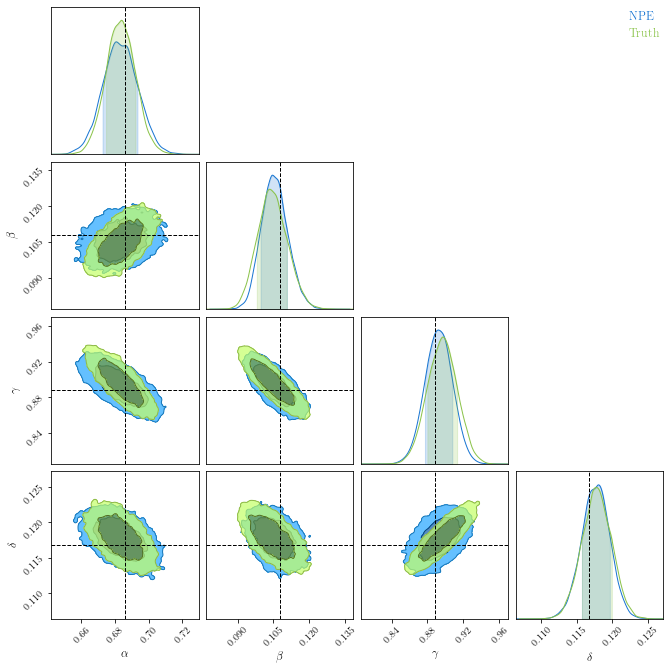

In [169]:
from chainconsumer import ChainConsumer

parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()

c.add_chain(sample_nd, parameters=parameters, name="NPE")
c.add_chain(reference_samples, parameters=parameters, name="Truth")

fig = c.plotter.plot(figsize=[10,10], truth=np.array(truth), 
                     extents=[[t - 5*std(reference_samples[:,i]), 
                               t + 5*std(reference_samples[:,i])] for i,t in enumerate(truth)])